In [1]:
%matplotlib inline
%env OMP_NUM_THREADS=10
%pylab inline
%load_ext autoreload
%autoreload 2
plt.rcParams['figure.figsize'] = [12, 12]

import sys
sys.path.append("../")

import cv2
from matplotlib.colors import LinearSegmentedColormap

from typing import List
import random

from eclipse_fit.eclipse_estimater import *
from eclipse_fit.eclipse_optimizer import *
from eclipse_fit.utils import *

import g2o

env: OMP_NUM_THREADS=10
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# generate random data

In [2]:
num_points: int = 100

center: np.ndarray = np.array([4, 8])
A: float = 12
B: float = 2
points: List[np.array] = []

phi = 30

R = get_rot_mat_from_angle(phi/180*np.pi)

debug = []

for _ in range(num_points):
    a = random.gauss(A, 0.03)
    b = random.gauss(B, 0.03)
    angle = random.uniform(0.0, 2.0 * np.pi)
    points.append(center + R @ np.array([a * np.cos(angle), b * np.sin(angle)]))
    
    debug.append(angle)

# set optimizer

In [3]:
max_iterations: int = 5000
verbose: bool = True
# TODO: Parse from command line

# Setup the optimizer
optimizer = g2o.SparseOptimizer()
solver = g2o.BlockSolverSE3(g2o.LinearSolverEigenSE3())
solver = g2o.OptimizationAlgorithmLevenberg(solver)
optimizer.set_algorithm(solver)

# Estimate eclipse roughly by svd

In [4]:
points = np.array(points)

init_angles,init_cx,init_cy,init_A,init_B,init_phi = est_eclipse_from_points(points)
print(init_cx,init_cy,init_A,init_B,init_phi / np.pi * 180)

3.9939156517955836 8.259798677843765 11.479801704029795 2.0487732542769144 -149.66397728679917


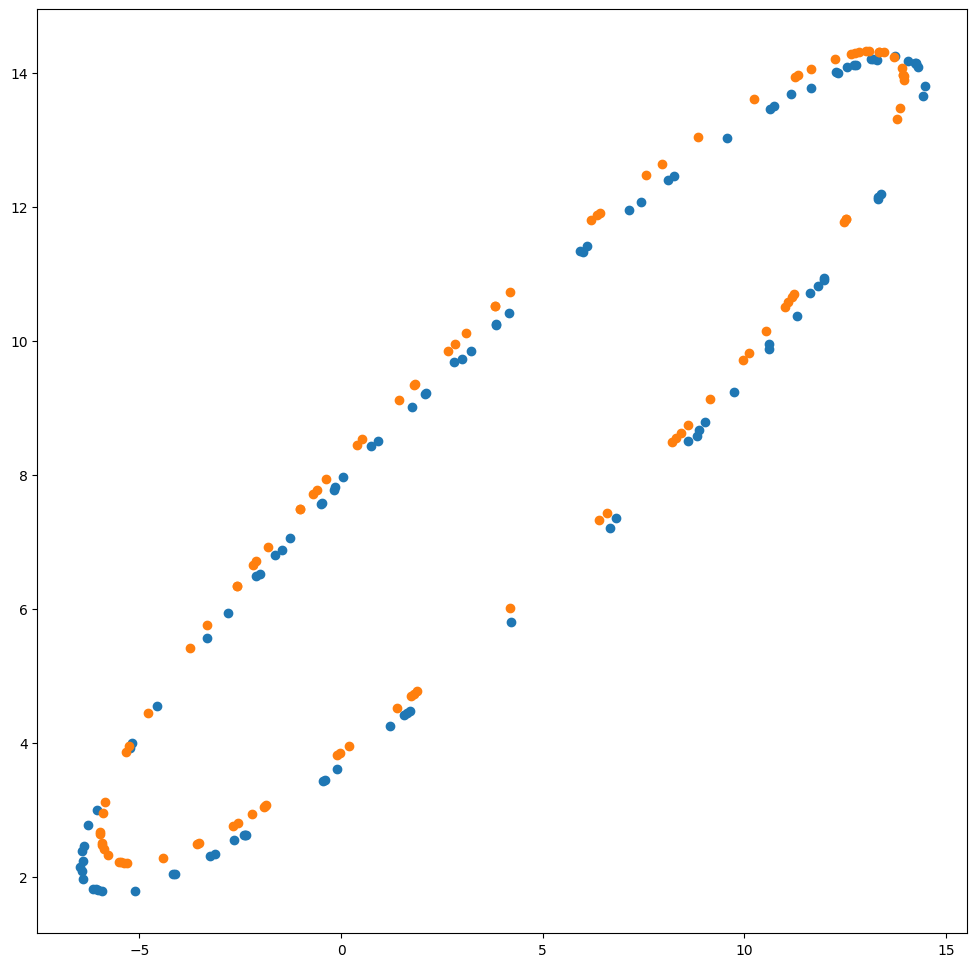

In [5]:
#cx_est,cy_est,a_est,b_est,phi_est = optimizer.vertices()[0].estimate()
#est_eclipse_xs, est_eclipse_ys = sample_ellipse(cx_est,cy_est,a_est,b_est)

R_init = get_rot_mat_from_angle(init_phi)

est_eclipse_xs = []
est_eclipse_ys = []
for i in range(1,num_points):
    init_angle = init_angles[i]
    
    x_,y_ = R_init @ np.array([init_A * np.cos(init_angle),init_B * np.sin(init_angle)])
    
    est_eclipse_xs.append(init_cx + x_)
    est_eclipse_ys.append(init_cy + y_)

dd = np.array(points).T
plt.scatter(dd[0,:],dd[1,:])
plt.scatter(est_eclipse_xs,est_eclipse_ys)

# Set Factor Graph

In [6]:
eclipse: VertexEclipse = VertexEclipse()
eclipse.set_id(0)
eclipse.set_estimate([init_cx,init_cy,init_A,init_B,init_phi])  # some initial value for the circle
optimizer.add_vertex(eclipse)

True

In [7]:
# 2. add the points we measured

est_rot = get_rot_mat_from_angle(init_phi)

for i,(point, angle) in enumerate(zip(points,init_angles),1):
        
    theta: VertexTheta = VertexTheta()
    theta.set_id(i)
    theta.set_estimate([angle])
    
    #if i < 2:
    #    theta.set_fixed(True)
    
    optimizer.add_vertex(theta)

    edge: EdgePointOnEclipse = EdgePointOnEclipse()
    edge.set_information(np.identity(2))
  
    edge.set_vertex(0, eclipse)
    edge.set_vertex(1, theta)

    edge.set_measurement(point)
    # print(f"error: {edge.compute_error()}")
    # print(f"edge slots: {dir(edge)}")
    optimizer.add_edge(edge)

In [8]:
print(f"Number of vertices: {len(optimizer.vertices())}")
print(f"Number of edges: {len(optimizer.edges())}")

Number of vertices: 101
Number of edges: 100


# Execute optimization

In [9]:
# perform the optimization
optimizer.initialize_optimization()
optimizer.set_verbose(verbose)
optimizer.optimize(max_iterations)

Cholesky failure, writing debug.txt (Hessian loadable by Octave)
Cholesky failure, writing debug.txt (Hessian loadable by Octave)
Cholesky failure, writing debug.txt (Hessian loadable by Octave)
Cholesky failure, writing debug.txt (Hessian loadable by Octave)
Cholesky failure, writing debug.txt (Hessian loadable by Octave)
Cholesky failure, writing debug.txt (Hessian loadable by Octave)
iteration= 0	 chi2= 29.579121	 time= 0.187096	 cumTime= 0.187096	 edges= 100	 schur= 0	 lambda= 699.050782	 levenbergIter= 7
iteration= 1	 chi2= 25.171054	 time= 0.0591738	 cumTime= 0.24627	 edges= 100	 schur= 0	 lambda= 233.016927	 levenbergIter= 1
iteration= 2	 chi2= 16.930543	 time= 0.0576288	 cumTime= 0.303899	 edges= 100	 schur= 0	 lambda= 77.672309	 levenbergIter= 1
Cholesky failure, writing debug.txt (Hessian loadable by Octave)
Cholesky failure, writing debug.txt (Hessian loadable by Octave)
iteration= 3	 chi2= 16.345306	 time= 0.104882	 cumTime= 0.408781	 edges= 100	 schur= 0	 lambda= 3314.0185

5000

3.994365664542604 7.997527764063583 11.974266592033413 2.0093282373263346 -149.98933532993942


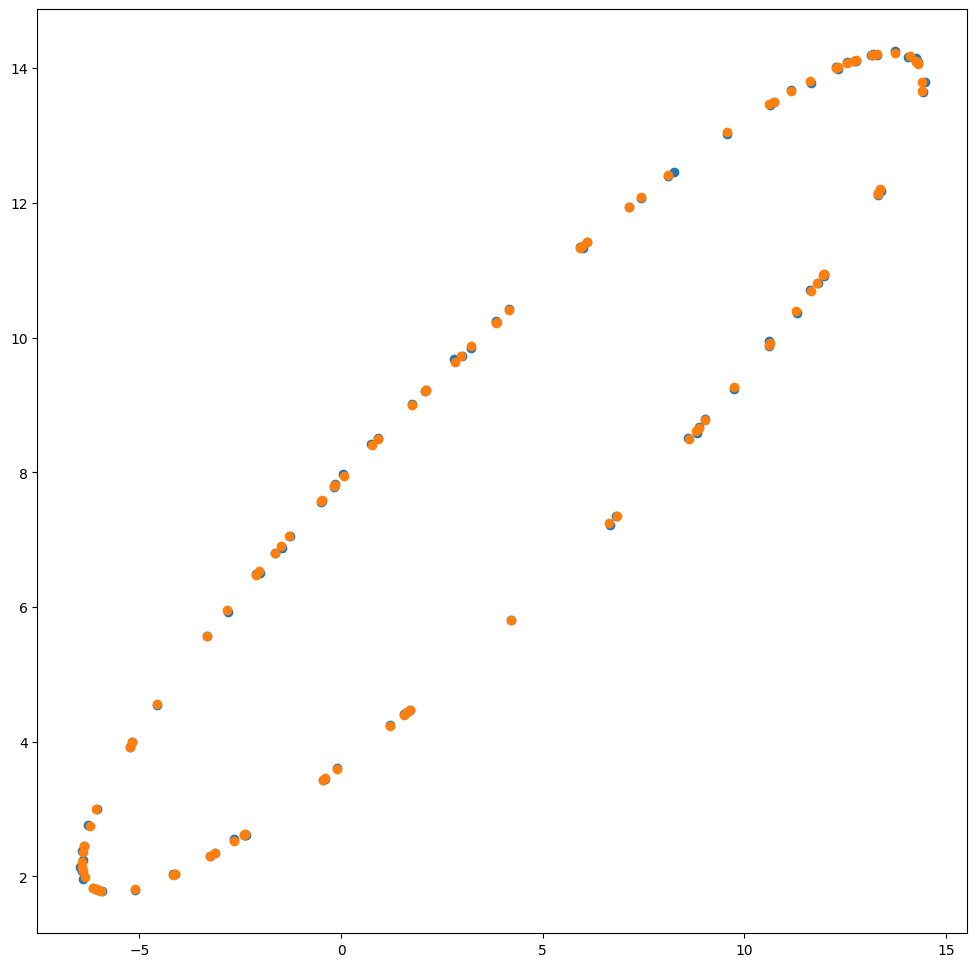

In [10]:
cx_est,cy_est,a_est,b_est,phi_est = optimizer.vertices()[0].estimate()
#est_eclipse_xs, est_eclipse_ys = sample_ellipse(cx_est,cy_est,a_est,b_est)

R_est = get_rot_mat_from_angle(phi_est)

est_eclipse_xs = []
est_eclipse_ys = []
for i in range(1,num_points):
    est_th = optimizer.vertices()[i].estimate()[0]
    
    x_,y_ = R_est @ np.array([a_est * np.cos(est_th),b_est * np.sin(est_th)])
    
    est_eclipse_xs.append(cx_est + x_)
    est_eclipse_ys.append(cy_est + y_)

print(cx_est,cy_est,a_est,b_est,phi_est / np.pi * 180)

dd = np.array(points).T
plt.scatter(dd[0,:],dd[1,:])
plt.scatter(est_eclipse_xs,est_eclipse_ys)